https://www.kaggle.com/code/josegabrielgonzalez/understat-series-xg-flow-chart/notebook

https://github.com/znstrider/highlight_text

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib.patches import Arc
import numpy as np
from highlight_text import fig_text
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import json

In [2]:
# Entering Real Sociedad vs Barcelona match link
link = "https://understat.com/match/22416"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')

# Get the shotsData, it's the second script executed in order
strings = scripts[1].string 

# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
shots_match = json.loads(json_data)

In [50]:
# Creating the 2 dfs

df_away = pd.DataFrame(shots_match['a'])
df_home = pd.DataFrame(shots_match['h'])

# Selecting only the useful columns

df_away = df_away[['minute','player',"a_team",'result','xG','h_a']]
df_home = df_home[['minute','player',"h_team",'result','xG','h_a']]

# Renaming columns 

df_away.rename(columns={"a_team": "team"})
df_home.rename(columns={"h_team": "team"})

# Changing data types

df_away = df_away.astype({"xG": float, "minute": float})
df_home = df_home.astype({"xG": float, "minute": float})

# Creating new column xG cumulative
df_away['xGcum'] = np.cumsum(df_away['xG'])
df_home['xGcum'] = np.cumsum(df_home['xG'])

In [51]:
zero_min_xg = pd.DataFrame({'minute': float('0.0'), 'player': 'NaN', 'h_team': 'Lazio',
                            'result': 'NaN', 'xG': float('0.0'), 'h_a': 'h', 'xGcum': float('0.0')}, index=[0])
df_away = pd.concat([zero_min_xg ,df_away.loc[:]]).reset_index(drop=True)
df_home = pd.concat([zero_min_xg ,df_home.loc[:]]).reset_index(drop=True)

#new_row = pd.DataFrame({'Courses':'Hyperion', 'Fee':24000, 'Duration':'55days', 'Discount':1800}, index=[0])
#df2 = pd.concat([new_row,df.loc[:]]).reset_index(drop=True)

In [52]:
# creating the dictionaries
x = df_home[df_home['result']=='Goal']['minute'].tolist()
x1 = df_away[df_away['result']=='Goal']['minute'].tolist()
y =df_home[df_home['result']=='Goal']['xGcum'].tolist()
y1 = df_away[df_away['result']=='Goal']['xGcum'].tolist()

# xG inside the scatterplots
y_plot =np.round(df_home[df_home['result']=='Goal']['xG'],2).tolist()
y1_plot = np.round(df_away[df_away['result']=='Goal']['xG'],2).tolist()

# Annotation text
text_home = df_home[df_home['result']=='Goal']['player'].tolist()
text_away = df_away[df_away['result']=='Goal']['player'].tolist()
label_home = df_home['h_team'].unique().tolist()
label_away = df_away['a_team'].unique().tolist()

# More annotation text
xGcum_away = str(np.round(df_away['xGcum'].iloc[-1],3))
xGcum_home = str(np.round(df_home['xGcum'].iloc[-1],3))
team_away = str(df_away['a_team'].iloc[-1])
team_home = str(df_home['h_team'].iloc[-1])

In [53]:
xGcum_away_int = np.round(df_away['xGcum'].iloc[-1],2)
xGcum_home_int = np.round(df_home['xGcum'].iloc[-1],2)

C:\Users\4krav\AppData\Local\Temp\ipykernel_13216\1233932220.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [1000]
C:\Users\4krav\AppData\Local\Temp\ipykernel_13216\1233932220.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1]._sizes = [1000]


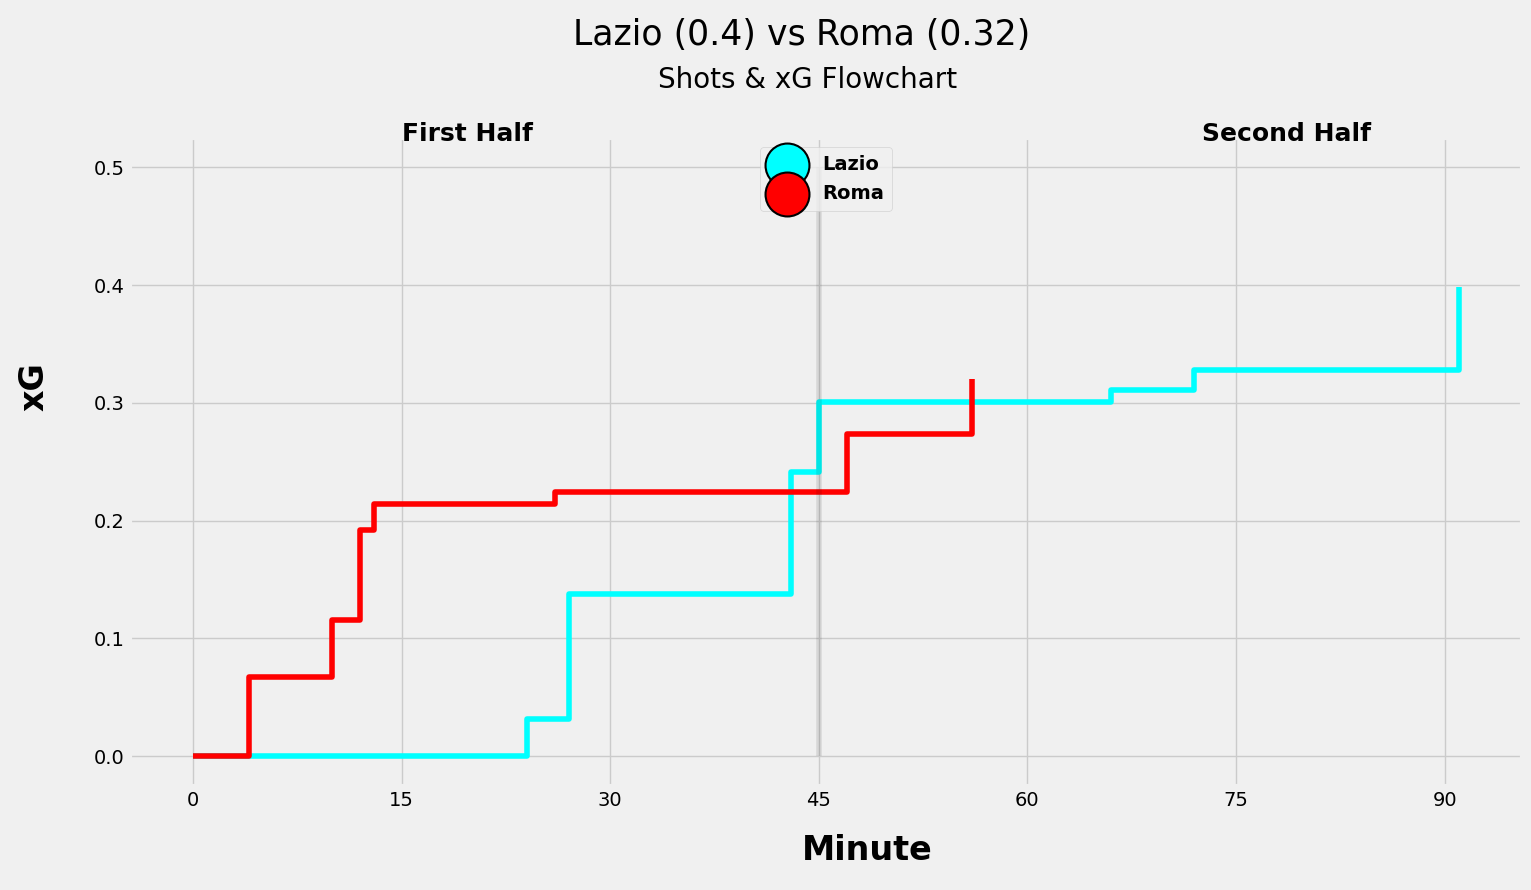

In [54]:
# plot style 
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots(figsize = (16,8))

# Step plot for Inter and Udinese 
ax.step(x = df_home['minute'] ,y = df_home['xGcum'] , where = 'post', color = 'cyan' ,linewidth = 4.0)
ax.step(x = df_away['minute'] ,y = df_away['xGcum'] , where = 'post', color = 'red' ,linewidth = 4.0)

#sns.scatterplot(x=x,y=y,s=430,marker='o',color='yellow')
ax.scatter(x=x,y=y, color='cyan', edgecolor='black',s=955, label="Lazio",linewidths=1.5,)
ax.scatter(x=x1,y=y1, color='red', edgecolor='black',s=955, label="Roma",linewidths=1.5)

#FILL AREA BETWEEN LINE AND X 
plt.fill_between(x, y, alpha=0.08, color='cyan')
plt.fill_between(x1, y1, alpha=0.08, color='red')

# https://stackoverflow.com/questions/63541222/fill-between-two-lines-lacking-common-x-values

# Text annotation for goals
for i in range(len(x1)):
    plt.annotate(text_away[i], (x1[i]- 3, y1[i] + 0.26),c='black',size=13)
for i in range(len(x)):
    plt.annotate(text_home[i], (x[i]- 3, y[i] + 0.26),c='black',size=13)

# legend
legend = ax.legend(loc="upper center",prop={'weight':'bold'}, labelcolor='black')
# These legends are for ax.scatter(x=x1,y=y1, color='red', edgecolor='black',s=955, label="AC Milan",linewidths=1.5)
# First is for the first team, second for the second
legend.legendHandles[0]._sizes = [1000]
legend.legendHandles[1]._sizes = [1000]

# title
fig_text(0.41,0.97, s="Shots & xG Flowchart\n", fontsize = 20, fontweight = "light", c='black')
fig_text(0.35,1.03,s=" <{} ({})> vs <{} ({}) >".format(team_home, xGcum_home_int, team_away, xGcum_away_int),
                                             highlight_textprops=[{"color":'blue'},
                                            {'color':"red"}], c='black', fontsize = 25, fontweight="light")

# text
fig_text(0.5,0.01, s="Minute\n", fontsize = 24, fontweight = "bold", color = "black")
fig_text(0.01,0.6, s="xG\n", fontsize = 24, fontweight = "bold", color = "black",rotation=90)
fig_text(0.25,0.9, s="First Half\n", fontsize = 18, fontweight = "bold", color = "black")
fig_text(0.75,0.9, s="Second Half\n", fontsize = 18, fontweight = "bold", color = "black")

# Finally a dotted line to separate the HT 
plt.vlines( ymin=0, ymax=0.5,x=45, color='black', alpha=0.1,linestyle="solid")
# ticks
plt.xticks([0,15,30,45,60,75,90], color='black')
plt.yticks([0,0.1,0.2,0.3,0.4,0.5], color='black')

# Annotate quality chances inside the scatterplots

# Home team
for i in range(len(x)):
    plt.annotate(y_plot[i], (x[i], y[i]),c='black',size=12,ha='center',va='center',fontweight='bold')
# Away team
for i in range(len(x1)):
    plt.annotate(y1_plot[i], (x1[i], y1[i]),c='black',size=12,ha='center',va='center',fontweight='bold')